In [1]:
from transformers import pipeline

import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

import pandas as pd

import pickle

import re
import os
import cv2
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
import torch
from PIL import Image,ImageFilter
import requests

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


Segmentation Models: using `keras` framework.


In [5]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/960_512/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized = 'rs19_val/960_512/masks_resized_track/'


# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

In [6]:
# pixel labels for each class
tram_track=3 
rail_track=12
track_bed= 15
rail_raised= 17
rail_embedded =18
veg = 8

# Prepare the mask label containing 5 labels related to tracks

- 200 tram images 
- Input images and Masks -> resized (NN) 512x256 , Median filter
- Prepare Binary Masks for all 5 options of labels related to track identification

In [10]:
image_dataset_resized = []
masked_dataset_resized = []

down_width = 960
down_height = 512
down_points = (down_width, down_height)

for i in range(len(tram_list)):
    image_tram = cv2.imread(path_images+tram_dict['filename_jpg'][i],1)
    mask_tram =  cv2.imread(path_masks+tram_dict['filename_mask'][i],0)
    # Median filter 3x3 and resizing 960x512 (such that the dimensions are divisible by 32 becuase of model requiremnet)
    #resize the input image by a scale factor using k-nearest interpolation such that the dimensions are divisible by 32
    #image_tram= image_tram.filter(ImageFilter.MedianFilter(size= 3))
    image_tram = cv2.medianBlur(image_tram, 3)
    image_resized= cv2.resize(image_tram, down_points, interpolation= cv2.INTER_NEAREST)

    cv2.imwrite(path_images_resized+tram_dict['filename_jpg'][i]+'.jpg', image_resized)
    image_dataset_resized.append(image_resized)

    #repeat for masks
    #mask_tram= mask_tram.filter(ImageFilter.MedianFilter(size= 3))
    mask_tram=cv2.medianBlur(mask_tram, 3)
    mask_resized= cv2.resize(mask_tram, down_points, interpolation= cv2.INTER_NEAREST)
 
    # Binary masks for track
    for k,val in enumerate(mask_resized):
        for j,val1 in enumerate(val):
            if (val1==tram_track or val1== rail_track or val1==rail_embedded or val1==rail_raised or val1== track_bed):
                val[j] = 1
            else:
                val[j] = 0
    
    masked_dataset_resized.append(mask_resized)
    cv2.imwrite(path_masks_resized+tram_dict['filename_mask'][i]+'.png', mask_resized)

image_dataset_resized = np.array(image_dataset_resized)
masked_dataset_resized = np.array(masked_dataset_resized)

#pickle.dump(image_dataset_resized, open('image_dataset_resized_10', "wb"))
#pickle.dump(masked_dataset_resized, open('mask_dataset_10', "wb"))
#pickle.dump(dataset_mask_multiplied, open('dataset_roi_mask_10', "wb"))

print(image_resized.shape)
print(mask_resized.shape)
print(image_dataset_resized.shape)
print(masked_dataset_resized.shape)

(512, 960, 3)
(512, 960)
(1318, 512, 960, 3)
(1318, 512, 960)


## expand dim of prepared mask due to model requiremnet 

In [28]:
print(masked_dataset_resized.shape)
masked_dataset_resized = np.expand_dims(masked_dataset_resized, axis=3)
print(masked_dataset_resized.shape)

(1318, 512, 960)
(1318, 512, 960, 1)


# Sanity check for prepared masks

In [11]:
test_list = ['rs00079','rs01562','rs02536','rs03764','rs04744','rs05410','rs07603','rs08095','rs08443']

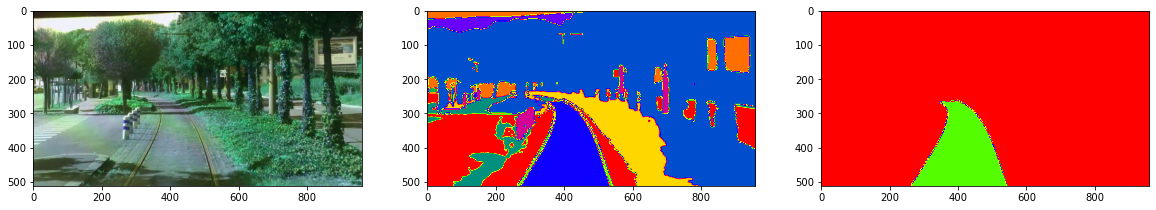

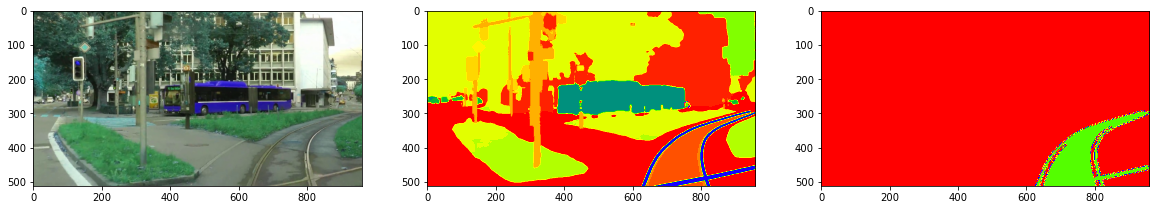

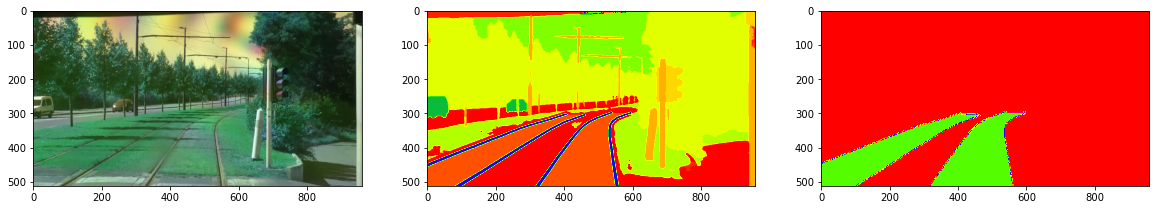

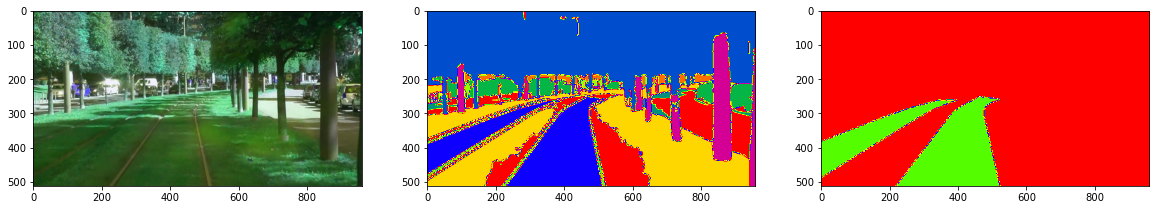

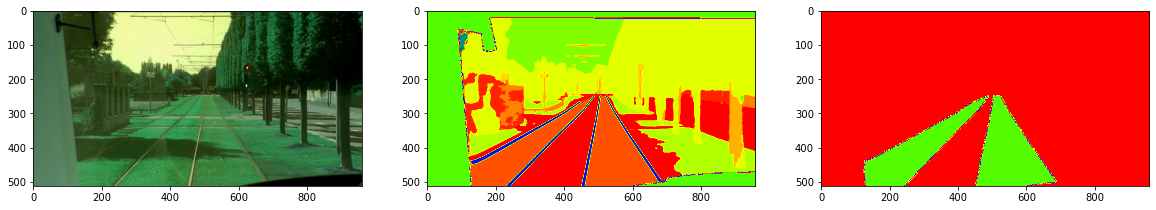

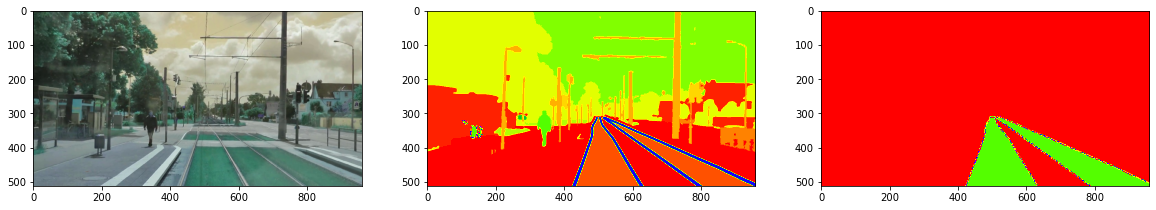

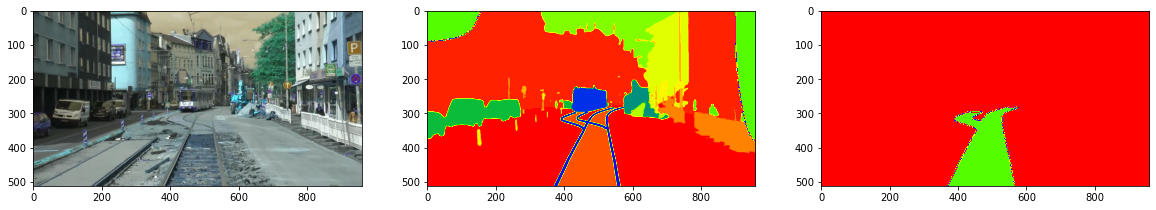

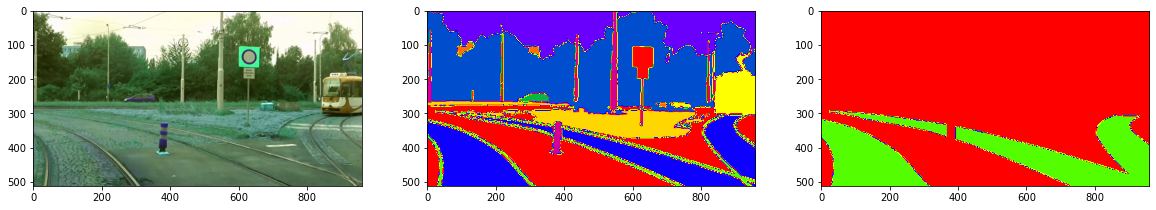

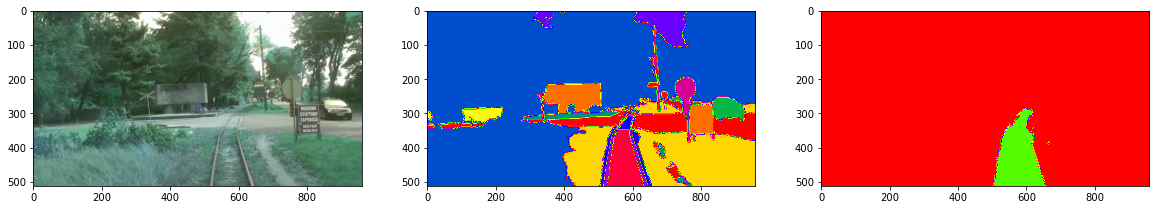

In [26]:
down_width = 960
down_height = 512
down_points = (down_width, down_height)

for imgfile in range(len(test_list)):
    chk_img= cv2.imread(path_images_resized+test_list[imgfile]+'.jpg.jpg',1)

    chk_msk= cv2.imread(path_masks_resized+test_list[imgfile]+'.png.png',0)


    org_msk = cv2.imread(path_masks+test_list[imgfile]+'.png',0)
    org_msk = cv2.medianBlur(org_msk,3)
    org_msk = cv2.resize(org_msk, down_points, interpolation= cv2.INTER_NEAREST)

    
    figure, axis_arr = plt.subplots(1,3, figsize=(20,20)) 
    axis_arr[0].imshow(chk_img)
    #axis_arr[0].get_title('image_resized')
    axis_arr[1].imshow(org_msk, cmap='prism')
    #axis_arr[1].get_title('mask_original_resized')
    axis_arr[2].imshow(chk_msk, cmap='prism')
    #axis_arr[2].get_title('mask_resized_track')

# Split train_test

In [30]:

X_train, X_test, y_train, y_test = train_test_split(image_dataset_resized[0:200], masked_dataset_resized[0:200], test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 512, 960, 3)
(40, 512, 960, 3)
(160, 512, 960, 1)
(40, 512, 960, 1)


In [31]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# define the model
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
#why classes=1 -> read more example
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [32]:
history = model.fit(X_train,
                    y_train,
                    batch_size=10, #back to 10 next time    
                    epochs=12,
                    verbose=1,
                    validation_data=(X_test,y_test))

model.save('saved_model/200in_768_1024_track_batch_10_epoch12.hdf5')

Epoch 1/12
16/16 [==============================] - 937s 60s/step - loss: 0.5598 - accuracy: 0.7521 - iou_score: 0.3205 - mse: 0.1849 - val_loss: 17.6911 - val_accuracy: 0.9098 - val_iou_score: 0.0422 - val_mse: 0.0896
Epoch 2/12
